In [1]:
import os
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm import tqdm

In [2]:
from code import model
from code.data import Dataset

In [3]:
root = os.getcwd()
batch = 8
forecast = 30
samples = 5
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# Model

In [4]:
dataset = Dataset(path=os.path.join(root, "training.csv"))

In [5]:
encoder = model.Extractor(in_channels=1, out_channels=1)
decoder = model.Decoder(classes=forecast) # forcast 30 days


predictor = model.Model(encoder=encoder, decoder=decoder).to(device)
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4)

In [6]:
trainloader = DataLoader(dataset, batch_size=batch, shuffle=False, num_workers=2)

In [ ]:
predictor.train()

for epoch in range(2000):

    epoch_loss = 0
    
    for index, data in tqdm(enumerate(trainloader)):

        optimizer.zero_grad()

        ref, gt = data # batch, 100, 4
        gt = gt[:, :, 0].to(device, dtype=torch.float)
 
        
        ref = torch.unsqueeze(ref, 1) # batch, channels, 100, 4
        ref = torch.transpose(ref, 2, 3) # batch, channels, 4, 100
        ref = ref.to(device, dtype=torch.float)

        _, pr = predictor(ref)

        
        pos = torch.isnan(gt)
        pos = ~ pos
        
        gt = gt[pos]
        pr = pr[pos]
#         gt = gt.view(batch, -1)
#         pr = pr.view(batch, -1)
        
        
        loss = torch.tensor(0, dtype=torch.float).to(device)

        ### sampling
        for sample in range(samples):
#             for _gt, _pr in zip(gt, pr):
        
            _gt = gt
            _pr = pr
            
            src = (torch.rand(_gt.size(0)) * _gt.size(0)).long()
            det = (torch.rand(_gt.size(0)) * _gt.size(0)).long()


            y_gt = _gt[det] - _gt[src]
            y_pr = _pr[det] - _pr[src]

            y_gt = torch.where(y_gt >= 0, torch.ones_like(y_gt), torch.zeros_like(y_gt))

            y_pr = nn.Sigmoid()(y_pr)


            loss += nn.BCELoss()(y_pr, y_gt)
                
        loss.backward()
        optimizer.step()
    
        epoch_loss += loss.item()
    
    print("\nEpoch: {}, bce= {:.3f}".format(epoch+1, epoch_loss))
 

145it [00:10, 13.91it/s]


Epoch: 1, bce= 504.971



145it [00:10, 13.51it/s]


Epoch: 2, bce= 504.571



145it [00:10, 13.56it/s]


Epoch: 3, bce= 504.211



145it [00:11, 13.08it/s]


Epoch: 4, bce= 503.943



145it [00:12, 11.68it/s]


Epoch: 5, bce= 503.867



145it [00:12, 11.93it/s]


Epoch: 6, bce= 503.751



145it [00:10, 13.48it/s]


Epoch: 7, bce= 503.410



145it [00:10, 13.98it/s]


Epoch: 8, bce= 503.570



145it [00:11, 13.09it/s]


Epoch: 9, bce= 503.365



145it [00:10, 13.46it/s]


Epoch: 10, bce= 503.148



145it [00:11, 12.26it/s]


Epoch: 11, bce= 502.952



145it [00:12, 11.69it/s]


Epoch: 12, bce= 502.942



145it [00:12, 11.83it/s]


Epoch: 13, bce= 502.879



145it [00:10, 13.59it/s]


Epoch: 14, bce= 502.690



145it [00:10, 13.81it/s]


Epoch: 15, bce= 502.505



145it [00:10, 13.85it/s]


Epoch: 16, bce= 502.442



145it [00:10, 13.54it/s]


Epoch: 17, bce= 502.257



145it [00:10, 13.56it/s]


Epoch: 18, bce= 502.297



145it [00:10, 13.67it/s]


Epoch: 19, bce= 502.029



145it [00:11, 12.11it/s]


Epoch: 20, bce= 501.868



145it [00:11, 12.16it/s]


Epoch: 21, bce= 502.015



145it [00:11, 12.16it/s]


Epoch: 22, bce= 501.826



145it [00:10, 13.89it/s]


Epoch: 23, bce= 501.582



145it [00:11, 13.17it/s]


Epoch: 24, bce= 501.470



145it [00:10, 13.30it/s]


Epoch: 25, bce= 501.260



145it [00:10, 13.47it/s]


Epoch: 26, bce= 501.151



145it [00:10, 13.70it/s]


Epoch: 27, bce= 501.089



145it [00:10, 13.85it/s]


Epoch: 28, bce= 500.911



145it [00:10, 13.52it/s]


Epoch: 29, bce= 500.604



145it [00:10, 13.65it/s]


Epoch: 30, bce= 500.686



145it [00:10, 13.92it/s]


Epoch: 31, bce= 500.418



145it [00:11, 13.13it/s]


Epoch: 32, bce= 500.340



145it [00:11, 12.23it/s]


Epoch: 33, bce= 500.128



145it [00:10, 13.81it/s]


Epoch: 34, bce= 499.873



145it [00:10, 13.42it/s]


Epoch: 35, bce= 499.507



145it [00:10, 13.45it/s]


Epoch: 36, bce= 499.360



145it [00:10, 13.63it/s]


Epoch: 37, bce= 499.362



145it [00:10, 13.59it/s]


Epoch: 38, bce= 499.051



145it [00:10, 13.32it/s]


Epoch: 39, bce= 498.857



145it [00:10, 13.59it/s]


Epoch: 40, bce= 498.586



145it [00:10, 13.80it/s]


Epoch: 41, bce= 498.367



145it [00:10, 13.39it/s]


Epoch: 42, bce= 497.561



145it [00:10, 13.42it/s]


Epoch: 43, bce= 497.538



145it [00:10, 13.62it/s]


Epoch: 44, bce= 497.043



145it [00:10, 13.99it/s]


Epoch: 45, bce= 496.637



145it [00:10, 14.42it/s]


Epoch: 46, bce= 496.604



145it [00:12, 11.96it/s]


Epoch: 47, bce= 495.997



145it [00:11, 12.95it/s]


Epoch: 48, bce= 495.531



145it [00:10, 13.57it/s]


Epoch: 49, bce= 495.019



145it [00:11, 12.44it/s]


Epoch: 50, bce= 494.788



145it [00:11, 12.15it/s]


Epoch: 51, bce= 494.207



145it [00:10, 13.78it/s]


Epoch: 52, bce= 493.837



145it [00:10, 14.43it/s]


Epoch: 53, bce= 493.196



145it [00:11, 12.77it/s]


Epoch: 54, bce= 492.969



145it [00:10, 14.11it/s]


Epoch: 55, bce= 492.513



145it [00:10, 13.66it/s]


Epoch: 56, bce= 492.547



145it [00:10, 13.39it/s]


Epoch: 57, bce= 492.425



145it [00:10, 14.18it/s]


Epoch: 58, bce= 492.048



145it [00:10, 14.14it/s]


Epoch: 59, bce= 491.343



145it [00:10, 13.98it/s]


Epoch: 60, bce= 490.897



145it [00:10, 13.73it/s]


Epoch: 61, bce= 491.201



145it [00:10, 14.23it/s]


Epoch: 62, bce= 490.498



145it [00:10, 13.88it/s]


Epoch: 63, bce= 490.041



145it [00:10, 14.15it/s]


Epoch: 64, bce= 489.806



145it [00:10, 13.68it/s]


Epoch: 65, bce= 488.877



145it [00:10, 13.63it/s]


Epoch: 66, bce= 489.214



145it [00:12, 12.04it/s]


Epoch: 67, bce= 488.046



145it [00:12, 11.84it/s]


Epoch: 68, bce= 487.899



145it [00:11, 12.39it/s]


Epoch: 69, bce= 487.913



145it [00:10, 13.93it/s]


Epoch: 70, bce= 487.293



145it [00:10, 13.60it/s]


Epoch: 71, bce= 486.738



145it [00:10, 13.27it/s]


Epoch: 72, bce= 485.924



145it [00:10, 13.45it/s]


Epoch: 73, bce= 485.926



145it [00:10, 13.93it/s]


Epoch: 74, bce= 485.190



145it [00:10, 13.55it/s]


Epoch: 75, bce= 487.388



145it [00:10, 13.55it/s]


Epoch: 76, bce= 484.310



145it [00:10, 13.95it/s]


Epoch: 77, bce= 486.221



145it [00:10, 13.50it/s]


Epoch: 78, bce= 491.668



145it [00:10, 13.40it/s]


Epoch: 79, bce= 483.306



145it [00:10, 13.51it/s]


Epoch: 80, bce= 484.740



145it [00:10, 13.53it/s]


Epoch: 81, bce= 482.777



145it [00:10, 13.48it/s]


Epoch: 82, bce= 491.381



145it [00:10, 13.41it/s]


Epoch: 83, bce= 482.479



145it [00:10, 13.67it/s]


Epoch: 84, bce= 480.628



145it [00:10, 14.06it/s]


Epoch: 85, bce= 480.976



145it [00:10, 13.51it/s]


Epoch: 86, bce= 479.461



145it [00:10, 13.33it/s]


Epoch: 87, bce= 479.863



145it [00:10, 13.68it/s]


Epoch: 88, bce= 478.433



145it [00:10, 13.49it/s]


Epoch: 89, bce= 478.255



145it [00:10, 13.59it/s]


Epoch: 90, bce= 477.119



145it [00:10, 13.79it/s]


Epoch: 91, bce= 478.394



145it [00:10, 14.18it/s]


Epoch: 92, bce= 477.063



145it [00:11, 13.10it/s]


Epoch: 93, bce= 477.539



145it [00:10, 13.31it/s]


Epoch: 94, bce= 476.975



145it [00:10, 13.50it/s]


Epoch: 95, bce= 476.481



145it [00:10, 14.08it/s]


Epoch: 96, bce= 477.394



145it [00:10, 13.55it/s]


Epoch: 97, bce= 476.016



145it [00:11, 12.19it/s]


Epoch: 98, bce= 475.547



145it [00:11, 12.40it/s]


Epoch: 99, bce= 474.217



145it [00:11, 12.49it/s]


Epoch: 100, bce= 474.202



145it [00:10, 14.10it/s]


Epoch: 101, bce= 472.093



145it [00:10, 14.08it/s]


Epoch: 102, bce= 472.149



145it [00:10, 13.71it/s]


Epoch: 103, bce= 470.812



145it [00:10, 14.06it/s]


Epoch: 104, bce= 469.381



145it [00:10, 13.45it/s]


Epoch: 105, bce= 469.085



145it [00:10, 13.70it/s]


Epoch: 106, bce= 467.049



145it [00:10, 13.61it/s]


Epoch: 107, bce= 466.767



145it [00:10, 13.60it/s]


Epoch: 108, bce= 464.282



145it [00:10, 13.77it/s]


Epoch: 109, bce= 462.090



145it [00:10, 13.86it/s]


Epoch: 110, bce= 460.478



145it [00:10, 13.43it/s]


Epoch: 111, bce= 459.210



145it [00:10, 13.97it/s]


Epoch: 112, bce= 459.664



145it [00:10, 13.76it/s]


Epoch: 113, bce= 469.798



145it [00:10, 14.16it/s]


Epoch: 114, bce= 462.893



145it [00:12, 11.94it/s]


Epoch: 115, bce= 456.411



145it [00:10, 13.62it/s]


Epoch: 116, bce= 460.990



145it [00:10, 13.56it/s]


Epoch: 117, bce= 453.272



145it [00:12, 11.61it/s]


Epoch: 118, bce= 454.504



145it [00:11, 13.06it/s]


Epoch: 119, bce= 452.509



145it [00:10, 13.68it/s]


Epoch: 120, bce= 452.810



145it [00:10, 13.73it/s]


Epoch: 121, bce= 451.135



145it [00:11, 13.02it/s]


Epoch: 122, bce= 451.194



145it [00:10, 13.80it/s]


Epoch: 123, bce= 451.600



145it [00:10, 13.58it/s]


Epoch: 124, bce= 450.943



145it [00:10, 13.50it/s]


Epoch: 125, bce= 451.549



145it [00:12, 11.87it/s]


Epoch: 126, bce= 455.489



145it [00:12, 11.98it/s]


Epoch: 127, bce= 456.585



145it [00:11, 12.96it/s]


Epoch: 128, bce= 450.839



145it [00:12, 12.05it/s]


Epoch: 129, bce= 452.123



145it [00:10, 13.32it/s]


Epoch: 130, bce= 452.895



145it [00:10, 13.95it/s]


Epoch: 131, bce= 464.106



145it [00:10, 13.45it/s]


Epoch: 132, bce= 470.568



145it [00:10, 13.85it/s]


Epoch: 133, bce= 473.178



145it [00:12, 12.05it/s]


Epoch: 134, bce= 469.574



145it [00:10, 13.67it/s]


Epoch: 135, bce= 461.156



145it [00:11, 13.08it/s]


Epoch: 136, bce= 458.441



145it [00:10, 13.86it/s]


Epoch: 137, bce= 458.728



145it [00:12, 11.86it/s]


Epoch: 138, bce= 451.760



145it [00:10, 13.67it/s]


Epoch: 139, bce= 447.360



145it [00:11, 13.00it/s]


Epoch: 140, bce= 448.962



145it [00:10, 13.40it/s]


Epoch: 141, bce= 451.268



145it [00:10, 13.57it/s]


Epoch: 142, bce= 450.093



145it [00:10, 13.47it/s]


Epoch: 143, bce= 446.148



145it [00:10, 14.13it/s]


Epoch: 144, bce= 445.962



145it [00:10, 13.43it/s]


Epoch: 145, bce= 444.207



145it [00:10, 13.44it/s]


Epoch: 146, bce= 443.299



145it [00:10, 13.66it/s]


Epoch: 147, bce= 435.605



145it [00:12, 12.08it/s]


Epoch: 148, bce= 433.650



145it [00:12, 11.99it/s]


Epoch: 149, bce= 432.005



145it [00:10, 13.80it/s]


Epoch: 150, bce= 427.512



145it [00:10, 13.60it/s]


Epoch: 151, bce= 427.858



145it [00:10, 13.79it/s]


Epoch: 152, bce= 427.675



145it [00:10, 13.78it/s]


Epoch: 153, bce= 425.506



145it [00:10, 13.26it/s]


Epoch: 154, bce= 422.760



145it [00:10, 13.42it/s]


Epoch: 155, bce= 416.632



145it [00:10, 13.91it/s]


Epoch: 156, bce= 419.410



145it [00:10, 13.86it/s]


Epoch: 157, bce= 421.755



145it [00:10, 13.70it/s]


Epoch: 158, bce= 415.068



145it [00:11, 13.14it/s]


Epoch: 159, bce= 413.515



145it [00:10, 13.63it/s]


Epoch: 160, bce= 420.072



145it [00:10, 13.76it/s]


Epoch: 161, bce= 422.803



145it [00:10, 13.68it/s]


Epoch: 162, bce= 414.265



145it [00:10, 13.55it/s]


Epoch: 163, bce= 410.244



145it [00:10, 13.84it/s]



Epoch: 164, bce= 407.182


145it [00:10, 13.83it/s]


Epoch: 165, bce= 406.028



145it [00:10, 13.80it/s]


Epoch: 166, bce= 408.418



145it [00:11, 12.34it/s]


Epoch: 167, bce= 407.660



145it [00:10, 13.22it/s]


Epoch: 168, bce= 402.284



145it [00:10, 13.48it/s]


Epoch: 169, bce= 405.591



145it [00:10, 13.32it/s]


Epoch: 170, bce= 402.590



145it [00:10, 13.81it/s]


Epoch: 171, bce= 404.577



145it [00:10, 14.09it/s]


Epoch: 172, bce= 406.496



145it [00:10, 13.50it/s]


Epoch: 173, bce= 402.974



145it [00:10, 13.52it/s]


Epoch: 174, bce= 398.758



145it [00:10, 13.55it/s]


Epoch: 175, bce= 397.755



145it [00:10, 13.68it/s]


Epoch: 176, bce= 393.525



145it [00:10, 13.70it/s]


Epoch: 177, bce= 395.886



145it [00:10, 13.47it/s]


Epoch: 178, bce= 393.053



145it [00:10, 14.01it/s]


Epoch: 179, bce= 390.194



145it [00:10, 13.87it/s]


Epoch: 180, bce= 395.280



145it [00:10, 13.86it/s]


Epoch: 181, bce= 428.980



145it [00:11, 12.26it/s]


Epoch: 182, bce= 407.526



145it [00:10, 13.50it/s]


Epoch: 183, bce= 397.958



145it [00:10, 13.22it/s]


Epoch: 184, bce= 384.216



145it [00:11, 12.90it/s]


Epoch: 185, bce= 383.899



145it [00:11, 13.08it/s]


Epoch: 186, bce= 383.760



145it [00:12, 11.90it/s]


Epoch: 187, bce= 381.773



145it [00:12, 11.84it/s]


Epoch: 188, bce= 380.678



145it [00:10, 13.48it/s]


Epoch: 189, bce= 385.764



145it [00:10, 13.35it/s]


Epoch: 190, bce= 414.726



145it [00:10, 13.56it/s]


Epoch: 191, bce= 383.595



145it [00:10, 13.51it/s]


Epoch: 192, bce= 382.357



145it [00:10, 13.52it/s]


Epoch: 193, bce= 377.579



145it [00:10, 13.53it/s]


Epoch: 194, bce= 376.646



145it [00:11, 12.48it/s]


Epoch: 195, bce= 388.364



145it [00:10, 13.23it/s]


Epoch: 196, bce= 383.409



145it [00:11, 13.03it/s]


Epoch: 197, bce= 377.904



145it [00:10, 13.29it/s]


Epoch: 198, bce= 374.301



145it [00:11, 13.14it/s]


Epoch: 199, bce= 378.075



145it [00:10, 13.66it/s]


Epoch: 200, bce= 378.932



145it [00:10, 14.01it/s]


Epoch: 201, bce= 395.433



145it [00:10, 13.92it/s]


Epoch: 202, bce= 384.329



145it [00:10, 14.16it/s]


Epoch: 203, bce= 372.823



145it [00:10, 13.72it/s]


Epoch: 204, bce= 369.019



145it [00:10, 13.35it/s]


Epoch: 205, bce= 372.232



145it [00:10, 13.56it/s]


Epoch: 206, bce= 370.480



145it [00:11, 12.73it/s]


Epoch: 207, bce= 370.317



145it [00:10, 14.07it/s]


Epoch: 208, bce= 365.590



145it [00:10, 14.11it/s]


Epoch: 209, bce= 362.389



145it [00:10, 13.80it/s]


Epoch: 210, bce= 361.956



145it [00:10, 14.06it/s]


Epoch: 211, bce= 370.699



145it [00:10, 13.36it/s]


Epoch: 212, bce= 400.943



145it [00:10, 13.88it/s]


Epoch: 213, bce= 385.201



145it [00:10, 13.92it/s]


Epoch: 214, bce= 367.292



145it [00:11, 12.43it/s]


Epoch: 215, bce= 366.480



145it [00:10, 13.71it/s]


Epoch: 216, bce= 366.125



145it [00:10, 13.65it/s]


Epoch: 217, bce= 372.559



145it [00:10, 13.21it/s]


Epoch: 218, bce= 371.799



145it [00:11, 12.34it/s]


Epoch: 219, bce= 361.743



145it [00:12, 11.95it/s]


Epoch: 220, bce= 359.593



145it [00:10, 13.75it/s]


Epoch: 221, bce= 359.132



145it [00:10, 14.05it/s]


Epoch: 222, bce= 360.145



145it [00:11, 12.22it/s]


Epoch: 223, bce= 364.341



145it [00:12, 11.67it/s]


Epoch: 224, bce= 363.416



145it [00:12, 11.45it/s]


Epoch: 225, bce= 369.214



145it [00:10, 13.91it/s]


Epoch: 226, bce= 375.842



145it [00:10, 13.81it/s]


Epoch: 227, bce= 363.759



145it [00:12, 12.04it/s]


Epoch: 228, bce= 360.657



145it [00:10, 13.65it/s]


Epoch: 229, bce= 359.123



145it [00:10, 13.75it/s]


Epoch: 230, bce= 358.265



145it [00:11, 12.15it/s]


Epoch: 231, bce= 366.804



145it [00:11, 12.17it/s]


Epoch: 232, bce= 370.638



145it [00:11, 12.53it/s]


Epoch: 233, bce= 361.236



145it [00:12, 11.92it/s]


Epoch: 234, bce= 362.259



145it [00:11, 12.34it/s]


Epoch: 235, bce= 355.912



145it [00:11, 12.24it/s]


Epoch: 236, bce= 360.183



145it [00:11, 12.30it/s]


Epoch: 237, bce= 359.469



145it [00:12, 12.08it/s]


Epoch: 238, bce= 356.957



145it [00:10, 13.55it/s]


Epoch: 239, bce= 351.485



145it [00:10, 13.66it/s]


Epoch: 240, bce= 351.048



145it [00:12, 11.91it/s]


Epoch: 241, bce= 352.520



145it [00:11, 12.63it/s]


Epoch: 242, bce= 373.373



145it [00:10, 13.21it/s]


Epoch: 243, bce= 413.654



145it [00:11, 13.12it/s]


Epoch: 244, bce= 368.770



145it [00:10, 14.14it/s]


Epoch: 245, bce= 358.369



145it [00:10, 13.34it/s]


Epoch: 246, bce= 351.745



145it [00:11, 12.29it/s]


Epoch: 247, bce= 349.294



145it [00:11, 13.14it/s]


Epoch: 248, bce= 366.339



145it [00:10, 13.62it/s]


Epoch: 249, bce= 358.989



145it [00:10, 13.30it/s]


Epoch: 250, bce= 365.336



145it [00:11, 13.13it/s]


Epoch: 251, bce= 360.313



145it [00:10, 13.60it/s]


Epoch: 252, bce= 352.797



145it [00:12, 11.80it/s]


Epoch: 253, bce= 353.576



145it [00:10, 13.21it/s]


Epoch: 254, bce= 351.719



145it [00:10, 13.55it/s]


Epoch: 255, bce= 354.430



145it [00:11, 13.00it/s]


Epoch: 256, bce= 349.015



145it [00:10, 13.43it/s]


Epoch: 257, bce= 347.189



145it [00:10, 13.54it/s]


Epoch: 258, bce= 397.381



145it [00:12, 12.05it/s]


Epoch: 259, bce= 421.778



145it [00:10, 13.45it/s]


Epoch: 260, bce= 438.607



145it [00:10, 13.76it/s]


Epoch: 261, bce= 392.575



145it [00:10, 13.77it/s]


Epoch: 262, bce= 372.787



145it [00:10, 13.38it/s]


Epoch: 263, bce= 359.632



145it [00:10, 13.78it/s]


Epoch: 264, bce= 357.827



145it [00:10, 13.41it/s]


Epoch: 265, bce= 354.432



145it [00:10, 14.26it/s]


Epoch: 266, bce= 351.035



145it [00:10, 13.96it/s]


Epoch: 267, bce= 352.851



145it [00:10, 13.70it/s]


Epoch: 268, bce= 350.387



145it [00:10, 13.54it/s]


Epoch: 269, bce= 348.788



145it [00:10, 13.21it/s]


Epoch: 270, bce= 354.761



145it [00:10, 13.19it/s]


Epoch: 271, bce= 346.823



145it [00:10, 14.13it/s]


Epoch: 272, bce= 352.062



145it [00:10, 13.72it/s]


Epoch: 273, bce= 353.226



145it [00:10, 13.85it/s]


Epoch: 274, bce= 358.018



145it [00:10, 13.79it/s]


Epoch: 275, bce= 349.644



145it [00:10, 13.34it/s]


Epoch: 276, bce= 342.656



145it [00:10, 14.45it/s]


Epoch: 277, bce= 342.043



145it [00:10, 13.53it/s]


Epoch: 278, bce= 342.524



145it [00:10, 13.33it/s]


Epoch: 279, bce= 342.502



145it [00:10, 14.07it/s]


Epoch: 280, bce= 342.975



145it [00:10, 13.98it/s]


Epoch: 281, bce= 343.106



145it [00:11, 13.07it/s]


Epoch: 282, bce= 363.854



145it [00:10, 13.63it/s]


Epoch: 283, bce= 358.280



145it [00:10, 13.25it/s]


Epoch: 284, bce= 352.978



145it [00:10, 13.56it/s]


Epoch: 285, bce= 361.499



145it [00:10, 13.85it/s]


Epoch: 286, bce= 348.754



145it [00:10, 13.65it/s]


Epoch: 287, bce= 348.136



145it [00:10, 13.88it/s]


Epoch: 288, bce= 343.274



145it [00:10, 14.05it/s]


Epoch: 289, bce= 343.641



145it [00:10, 14.08it/s]


Epoch: 290, bce= 347.406



145it [00:10, 14.14it/s]


Epoch: 291, bce= 349.827



145it [00:10, 13.41it/s]


Epoch: 292, bce= 345.832



145it [00:10, 13.25it/s]


Epoch: 293, bce= 346.497



145it [00:10, 13.30it/s]


Epoch: 294, bce= 349.671



145it [00:10, 13.83it/s]


Epoch: 295, bce= 340.102



145it [00:10, 13.82it/s]


Epoch: 296, bce= 338.435



145it [00:11, 13.16it/s]


Epoch: 297, bce= 340.081



145it [00:10, 13.43it/s]


Epoch: 298, bce= 337.083



145it [00:10, 14.12it/s]


Epoch: 299, bce= 337.779



145it [00:10, 13.76it/s]


Epoch: 300, bce= 337.700



145it [00:11, 12.23it/s]


Epoch: 301, bce= 340.045



145it [00:11, 12.50it/s]


Epoch: 302, bce= 339.421



145it [00:11, 13.07it/s]


Epoch: 303, bce= 355.931



145it [00:11, 12.97it/s]


Epoch: 304, bce= 350.976



145it [00:10, 13.38it/s]


Epoch: 305, bce= 357.129



145it [00:10, 13.72it/s]


Epoch: 306, bce= 408.224



145it [00:12, 11.88it/s]


Epoch: 307, bce= 396.768



145it [00:10, 13.57it/s]


Epoch: 308, bce= 352.348



145it [00:10, 13.47it/s]


Epoch: 309, bce= 343.360



145it [00:10, 13.80it/s]


Epoch: 310, bce= 339.730



145it [00:10, 13.20it/s]


Epoch: 311, bce= 335.063



145it [00:11, 13.02it/s]


Epoch: 312, bce= 336.367



145it [00:10, 14.07it/s]


Epoch: 313, bce= 334.285



145it [00:12, 11.83it/s]


Epoch: 314, bce= 335.084



145it [00:11, 12.91it/s]


Epoch: 315, bce= 334.952



145it [00:10, 13.82it/s]


Epoch: 316, bce= 333.112



145it [00:10, 13.57it/s]


Epoch: 317, bce= 336.991



145it [00:10, 13.61it/s]


Epoch: 318, bce= 337.378



145it [00:12, 11.89it/s]


Epoch: 319, bce= 344.271



145it [00:12, 11.72it/s]


Epoch: 320, bce= 360.041



145it [00:10, 13.33it/s]


Epoch: 321, bce= 358.248



145it [00:10, 13.82it/s]


Epoch: 322, bce= 354.495



145it [00:10, 14.10it/s]


Epoch: 323, bce= 345.658



145it [00:10, 13.38it/s]


Epoch: 324, bce= 339.254



145it [00:10, 13.34it/s]


Epoch: 325, bce= 340.559



145it [00:10, 13.49it/s]


Epoch: 326, bce= 336.819



145it [00:10, 13.20it/s]


Epoch: 327, bce= 338.004



145it [00:10, 13.68it/s]


Epoch: 328, bce= 334.887



145it [00:10, 13.84it/s]


Epoch: 329, bce= 339.367



145it [00:11, 12.96it/s]


Epoch: 330, bce= 337.175



145it [00:10, 13.43it/s]


Epoch: 331, bce= 335.004



145it [00:10, 13.23it/s]


Epoch: 332, bce= 331.747



145it [00:10, 13.66it/s]


Epoch: 333, bce= 340.993



145it [00:11, 12.76it/s]


Epoch: 334, bce= 337.053



145it [00:10, 14.05it/s]


Epoch: 335, bce= 333.273



145it [00:10, 13.99it/s]


Epoch: 336, bce= 338.715



145it [00:10, 13.88it/s]


Epoch: 337, bce= 340.985



145it [00:11, 12.11it/s]


Epoch: 338, bce= 334.168



145it [00:11, 12.25it/s]


Epoch: 339, bce= 335.277



145it [00:12, 11.86it/s]


Epoch: 340, bce= 333.614



145it [00:11, 12.85it/s]


Epoch: 341, bce= 336.787



145it [00:11, 12.69it/s]


Epoch: 342, bce= 334.908



145it [00:10, 13.86it/s]


Epoch: 343, bce= 333.186



145it [00:11, 13.10it/s]


Epoch: 344, bce= 331.012



145it [00:11, 13.18it/s]


Epoch: 345, bce= 330.123



145it [00:10, 13.70it/s]


Epoch: 346, bce= 338.201



145it [00:10, 13.36it/s]


Epoch: 347, bce= 334.459



145it [00:10, 13.69it/s]


Epoch: 348, bce= 332.116



145it [00:11, 13.05it/s]


Epoch: 349, bce= 331.179



145it [00:10, 13.87it/s]


Epoch: 350, bce= 338.591



145it [00:10, 13.96it/s]


Epoch: 351, bce= 339.237



145it [00:10, 13.74it/s]


Epoch: 352, bce= 340.866



145it [00:11, 12.80it/s]


Epoch: 353, bce= 342.472



145it [00:10, 13.33it/s]


Epoch: 354, bce= 334.548



145it [00:11, 13.13it/s]


Epoch: 355, bce= 333.049



145it [00:10, 13.88it/s]


Epoch: 356, bce= 332.206



145it [00:10, 13.53it/s]


Epoch: 357, bce= 329.048



145it [00:10, 13.82it/s]


Epoch: 358, bce= 331.362



145it [00:10, 13.55it/s]


Epoch: 359, bce= 328.775



145it [00:10, 13.87it/s]


Epoch: 360, bce= 327.911



145it [00:10, 13.62it/s]


Epoch: 361, bce= 327.701



145it [00:10, 13.70it/s]


Epoch: 362, bce= 327.033



145it [00:10, 13.65it/s]


Epoch: 363, bce= 326.926



145it [00:10, 14.23it/s]


Epoch: 364, bce= 334.360



145it [00:10, 13.49it/s]


Epoch: 365, bce= 335.816



145it [00:10, 13.81it/s]


Epoch: 366, bce= 336.728



145it [00:11, 13.17it/s]


Epoch: 367, bce= 328.125



145it [00:10, 13.80it/s]


Epoch: 368, bce= 326.822



145it [00:10, 13.62it/s]


Epoch: 369, bce= 329.512



145it [00:10, 14.03it/s]


Epoch: 370, bce= 349.525



145it [00:10, 14.01it/s]


Epoch: 371, bce= 338.117



145it [00:10, 14.05it/s]


Epoch: 372, bce= 327.577



145it [00:10, 14.06it/s]


Epoch: 373, bce= 326.319



145it [00:10, 13.93it/s]


Epoch: 374, bce= 324.739



145it [00:10, 13.79it/s]


Epoch: 375, bce= 330.312



145it [00:10, 13.40it/s]


Epoch: 376, bce= 327.581



145it [00:10, 13.94it/s]


Epoch: 377, bce= 326.251



145it [00:10, 13.46it/s]


Epoch: 378, bce= 325.264



145it [00:10, 13.25it/s]


Epoch: 379, bce= 324.986



145it [00:10, 14.17it/s]


Epoch: 380, bce= 325.773



145it [00:10, 13.66it/s]


Epoch: 381, bce= 339.750



145it [00:10, 13.31it/s]


Epoch: 382, bce= 367.693



145it [00:10, 14.07it/s]


Epoch: 383, bce= 385.435



145it [00:10, 13.81it/s]


Epoch: 384, bce= 330.480



145it [00:10, 13.86it/s]


Epoch: 385, bce= 326.374



145it [00:11, 12.26it/s]


Epoch: 386, bce= 322.812



145it [00:12, 12.06it/s]


Epoch: 387, bce= 321.899



145it [00:10, 13.50it/s]


Epoch: 388, bce= 320.219



145it [00:10, 13.71it/s]


Epoch: 389, bce= 320.283



145it [00:10, 13.94it/s]


Epoch: 390, bce= 320.275



145it [00:10, 13.77it/s]


Epoch: 391, bce= 319.431



145it [00:10, 13.62it/s]


Epoch: 392, bce= 318.839



145it [00:12, 11.76it/s]


Epoch: 393, bce= 319.169



145it [00:11, 12.17it/s]


Epoch: 394, bce= 319.649



145it [00:10, 13.73it/s]


Epoch: 395, bce= 321.004



145it [00:10, 14.11it/s]


Epoch: 396, bce= 321.733



145it [00:11, 12.97it/s]


Epoch: 397, bce= 319.048



145it [00:10, 13.45it/s]


Epoch: 398, bce= 319.484



145it [00:11, 12.94it/s]


Epoch: 399, bce= 320.506



145it [00:12, 11.82it/s]


Epoch: 400, bce= 320.387



145it [00:10, 13.76it/s]


Epoch: 401, bce= 318.244



145it [00:11, 13.01it/s]


Epoch: 402, bce= 319.052



145it [00:11, 13.04it/s]


Epoch: 403, bce= 335.100



145it [00:11, 12.55it/s]


Epoch: 404, bce= 328.771



145it [00:11, 12.58it/s]


Epoch: 405, bce= 325.326



145it [00:10, 13.49it/s]


Epoch: 406, bce= 321.023



145it [00:10, 13.20it/s]


Epoch: 407, bce= 316.707



145it [00:10, 13.66it/s]


Epoch: 408, bce= 317.341



145it [00:10, 13.25it/s]


Epoch: 409, bce= 315.587



145it [00:10, 13.94it/s]


Epoch: 410, bce= 333.276



145it [00:10, 13.96it/s]


Epoch: 411, bce= 345.077



145it [00:10, 13.92it/s]


Epoch: 412, bce= 324.063



145it [00:10, 13.61it/s]


Epoch: 413, bce= 317.544



145it [00:10, 13.91it/s]


Epoch: 414, bce= 314.797



145it [00:10, 13.72it/s]


Epoch: 415, bce= 316.076



145it [00:12, 11.92it/s]


Epoch: 416, bce= 313.602



145it [00:10, 13.75it/s]


Epoch: 417, bce= 311.846



145it [00:10, 14.02it/s]


Epoch: 418, bce= 311.618



145it [00:10, 13.54it/s]


Epoch: 419, bce= 315.098



145it [00:10, 13.86it/s]


Epoch: 420, bce= 314.730



145it [00:11, 13.03it/s]


Epoch: 421, bce= 315.379



145it [00:10, 13.34it/s]


Epoch: 422, bce= 319.734



145it [00:10, 13.79it/s]


Epoch: 423, bce= 320.903



145it [00:10, 13.59it/s]


Epoch: 424, bce= 316.122



145it [00:10, 13.62it/s]


Epoch: 425, bce= 316.539



145it [00:10, 13.18it/s]


Epoch: 426, bce= 315.540



145it [00:10, 13.59it/s]


Epoch: 427, bce= 315.218



145it [00:10, 13.62it/s]


Epoch: 428, bce= 314.623



145it [00:10, 13.70it/s]


Epoch: 429, bce= 311.110



145it [00:10, 13.88it/s]


Epoch: 430, bce= 310.417



145it [00:10, 13.26it/s]


Epoch: 431, bce= 314.129



145it [00:10, 13.52it/s]


Epoch: 432, bce= 312.356



145it [00:10, 13.68it/s]


Epoch: 433, bce= 317.204



145it [00:10, 13.41it/s]


Epoch: 434, bce= 315.225



145it [00:10, 13.24it/s]


Epoch: 435, bce= 313.159



145it [00:10, 13.70it/s]


Epoch: 436, bce= 316.552



145it [00:10, 13.23it/s]


Epoch: 437, bce= 309.525



145it [00:10, 13.63it/s]


Epoch: 438, bce= 310.397



145it [00:10, 13.50it/s]


Epoch: 439, bce= 310.572



145it [00:10, 13.91it/s]


Epoch: 440, bce= 320.866



145it [00:10, 14.16it/s]


Epoch: 441, bce= 326.490



145it [00:11, 12.88it/s]


Epoch: 442, bce= 316.468



145it [00:10, 13.40it/s]


Epoch: 443, bce= 314.517



145it [00:11, 13.14it/s]


Epoch: 444, bce= 309.136



145it [00:10, 13.45it/s]


Epoch: 445, bce= 307.395



145it [00:10, 13.23it/s]


Epoch: 446, bce= 306.315



145it [00:10, 13.51it/s]


Epoch: 447, bce= 313.047



145it [00:10, 13.50it/s]


Epoch: 448, bce= 320.380



145it [00:10, 13.49it/s]


Epoch: 449, bce= 313.002



145it [00:11, 12.76it/s]


Epoch: 450, bce= 308.306



145it [00:11, 12.36it/s]


Epoch: 451, bce= 320.526



145it [00:10, 14.03it/s]


Epoch: 452, bce= 315.844



145it [00:10, 13.98it/s]


Epoch: 453, bce= 307.573



145it [00:10, 13.81it/s]


Epoch: 454, bce= 305.033



145it [00:12, 11.72it/s]


Epoch: 455, bce= 304.721



145it [00:12, 11.69it/s]


Epoch: 456, bce= 301.791



145it [00:10, 13.63it/s]


Epoch: 457, bce= 305.665



145it [00:10, 13.55it/s]


Epoch: 458, bce= 303.845



145it [00:11, 13.07it/s]


Epoch: 459, bce= 301.486



145it [00:10, 13.28it/s]


Epoch: 460, bce= 301.978



145it [00:10, 13.96it/s]


Epoch: 461, bce= 301.972



145it [00:10, 14.08it/s]


Epoch: 462, bce= 303.882



145it [00:10, 13.73it/s]


Epoch: 463, bce= 306.657



145it [00:10, 13.46it/s]


Epoch: 464, bce= 305.955



145it [00:11, 13.08it/s]


Epoch: 465, bce= 303.626



145it [00:10, 13.58it/s]


Epoch: 466, bce= 303.116



145it [00:10, 13.47it/s]


Epoch: 467, bce= 299.719



145it [00:10, 13.25it/s]


Epoch: 468, bce= 303.121



145it [00:10, 13.27it/s]


Epoch: 469, bce= 317.929



145it [00:10, 13.29it/s]


Epoch: 470, bce= 317.473



83it [00:06, 13.70it/s]

In [ ]:
@torch.no_grad()
def test(predictor, dataloader):
    
    import math
    predictor.eval()

    predict = []
    forward = []

    for index, data in tqdm(enumerate(dataloader)):

        data, _ = data # batch, 100, 4

        data = torch.unsqueeze(data, 1) # batch, channels, 100, 4
        data = torch.transpose(data, 2, 3) # batch, channels, 4, 100

        data = data.to(device, dtype=torch.float)

        _, pr = predictor(data)
        
        pr = pr.view(1, -1).detach().cpu().numpy().tolist()
        
        if len(forward) == 0:
            forward = pr
            forward = [p * math.pow(2, i) for i, p in enumerate(forward)]
        else:
            predict.append(forward[0])
            forward = forward[1:] # pop the first element
            forward += [0]
            
            pr = [p * math.pow(2, i+1) for i, p in enumerate(pr)]
            
            forward = [sum(x) for x in zip(forward, pr)]
            
    predict += forward
    
    return predict

In [11]:
nn.BCELoss()(torch.tensor(np.nan), torch.tensor(0.2))

RuntimeError: all elements of input should be between 0 and 1

In [ ]:
checkpoint = {
    'model_stat': predictor.state_dict(),
    'optimizer_stat': optimizer.state_dict(),
}

torch.save(checkpoint, os.path.join(root,
                                    "code",
                                    "pred_1.pth"))

In [ ]:
pred = predictor

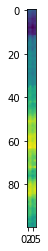

In [12]:
plt.imshow(dataset[0])

In [26]:
dataset[1259]

array([], shape=(0, 4), dtype=float64)

In [24]:
len(dataset)

1158